# Setup

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LeaveOneOut
import scipy.stats as stats


In [68]:
snow = pd.read_csv('./weather_delay_SNOW.csv').dropna(subset=['mean_arrival_delay'])
# Drop the top day since it were the result of a major snowstorm and it makes the model super unstable
snow = snow.drop(index=snow['mean_arrival_delay'].idxmax())

control = pd.read_csv('./weather_delay_CONTROL.csv').dropna(subset=['mean_arrival_delay'])

combined = pd.concat([snow, control], ignore_index=True)

snow

,date,temp,ground_code,ground_expl,prec_mm_total_24h,prec_mm_6h,snow_depth_cm,snow_depth_cm_accumulated,month,day,year,dow,dow_name,holiday,mean_arrival_delay,mean_net_additional_delay,mean_abs_additional_delay,mean_delay_recovery_index
0,2021-01-07,0.0,17,complete_snow_loose_dry,0.7,0.4,1.0,1.0,1,7,2021,3,Thursday,False,56.006122,-2.540816,33.985714,27.871429
1,2021-01-11,-3.0,17,complete_snow_loose_dry,26.6,0.0,4.0,4.0,1,11,2021,0,Monday,False,151.557604,3.520737,36.624424,28.092166
2,2021-01-13,-2.0,17,complete_snow_loose_dry,6.1,0.0,2.0,1.0,1,13,2021,2,Wednesday,False,141.314484,2.566468,32.602183,26.926587
3,2021-01-14,-2.7,17,complete_snow_loose_dry,1.0,1.2,12.0,10.0,1,14,2021,3,Thursday,False,181.561508,5.355159,34.275794,26.894841
4,2021-01-15,-9.9,17,complete_snow_loose_dry,0.5,0.0,14.0,2.0,1,15,2021,4,Friday,False,236.531746,7.521825,36.501984,26.716270
5,2021-01-26,-3.1,17,complete_snow_loose_dry,0.0,0.0,6.0,6.0,1,26,2021,1,Tuesday,False,189.316729,4.507519,33.501880,25.949248
6,2021-01-29,-4.0,17,complete_snow_loose_dry,0.3,0.0,17.0,12.0,1,29,2021,4,Friday,False,158.557540,4.346230,32.991071,26.132937
7,2021-02-03,-6.0,17,complete_snow_loose_dry,0.3,0.0,24.0,12.0,2,3,2021,2,Wednesday,False,247.625000,9.083333,36.595238,26.093254
8,2021-02-11,-11.8,17,complete_snow_loose_dry,0.1,0.1,16.0,2.0,2,11,2021,3,Thursday,False,198.297619,4.655754,34.782738,27.013889
9,2021-02-12,-10.7,17,complete_snow_loose_dry,0.0,0.0,17.0,1.0,2,12,2021,4,Friday,False,158.450000,2.608163,35.661224,29.077551


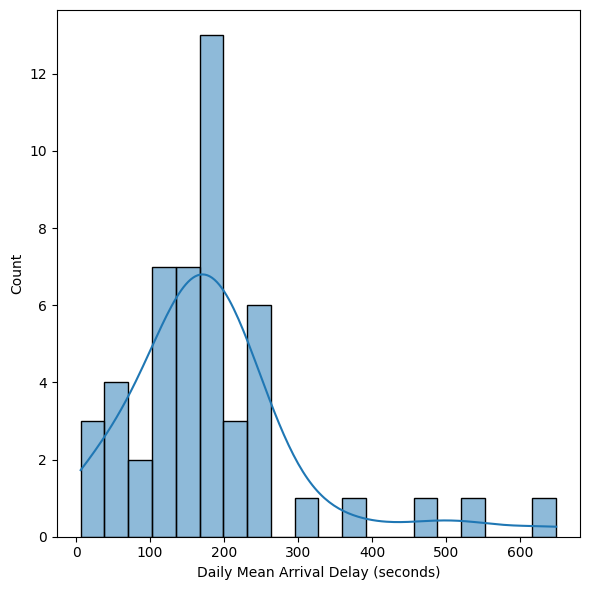

In [70]:
plt.figure(figsize=(6, 6))
sns.histplot(snow["mean_arrival_delay"], bins=20, kde=True)
plt.xlabel('Daily Mean Arrival Delay (seconds)')
plt.tight_layout()
plt.show()

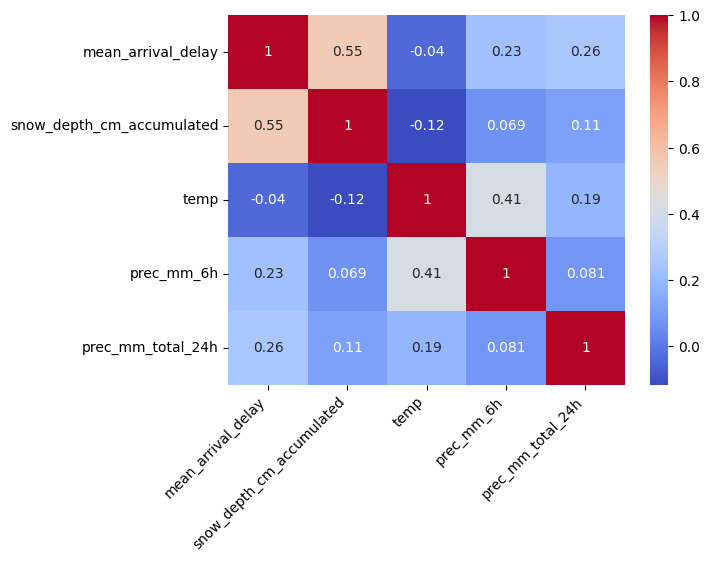

In [72]:
# Check correlations
numeric_regressor_candidates = ["snow_depth_cm_accumulated", "temp", "prec_mm_6h", "prec_mm_total_24h"]

correlation_matrix = snow[["mean_arrival_delay"] + numeric_regressor_candidates].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.show()

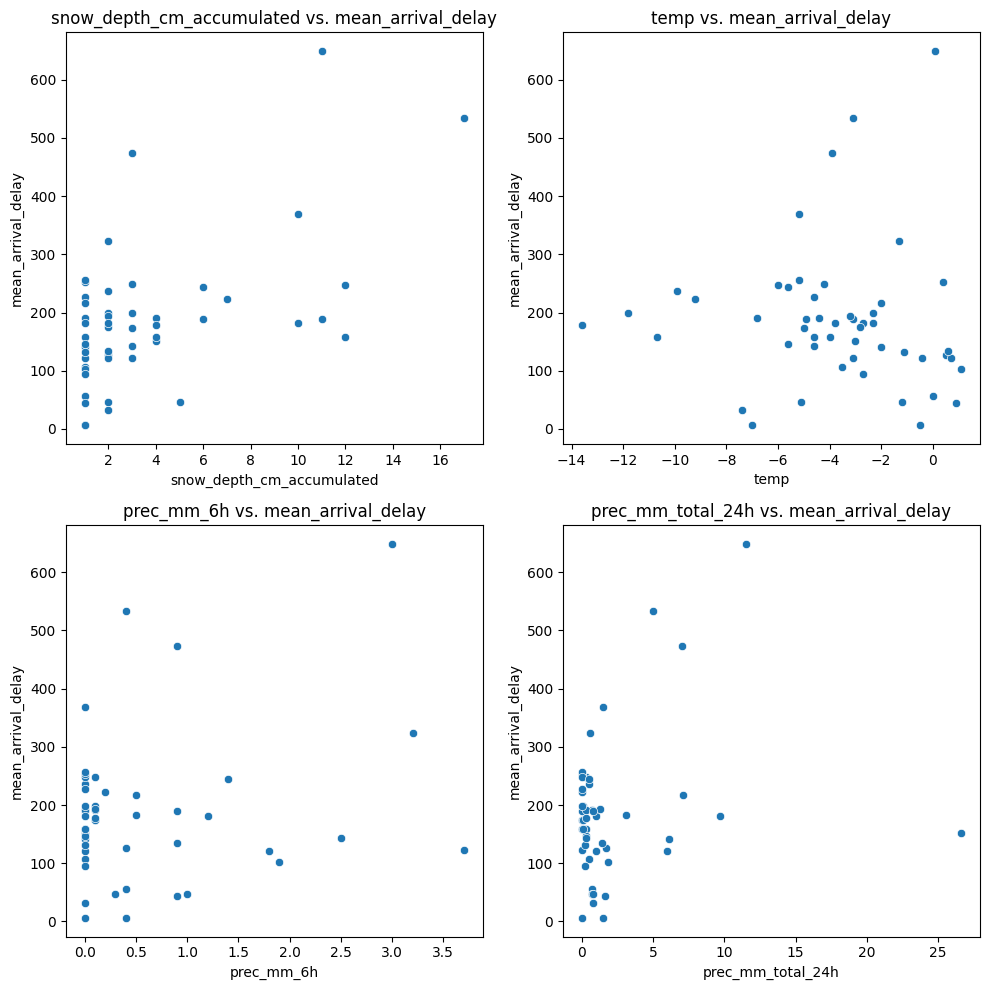

In [74]:
# Plot scatter plots for each numeric regressor candidate
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, col in enumerate(numeric_regressor_candidates):
    sns.scatterplot(data=snow, x=col, y='mean_arrival_delay', ax=axs[i])
    axs[i].set_title(f'{col} vs. mean_arrival_delay')

plt.tight_layout()
plt.show()

# Simple Regression

In [75]:
# Fit a simple OLS model
model = smf.ols(formula="mean_arrival_delay ~ snow_depth_cm_accumulated", data=snow).fit()
print(model.summary())

# Summary: significant, decent R-squared of 0.304
# Outcome: Check residuals

                            OLS Regression Results                            
Dep. Variable:     mean_arrival_delay   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     20.98
Date:                Sun, 11 May 2025   Prob (F-statistic):           3.31e-05
Time:                        22:16:19   Log-Likelihood:                -301.02
No. Observations:                  50   AIC:                             606.0
Df Residuals:                      48   BIC:                             609.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Summary: Effect is statistically significant and meaningful, but the diagnostics indicate that assumptions are probably violated

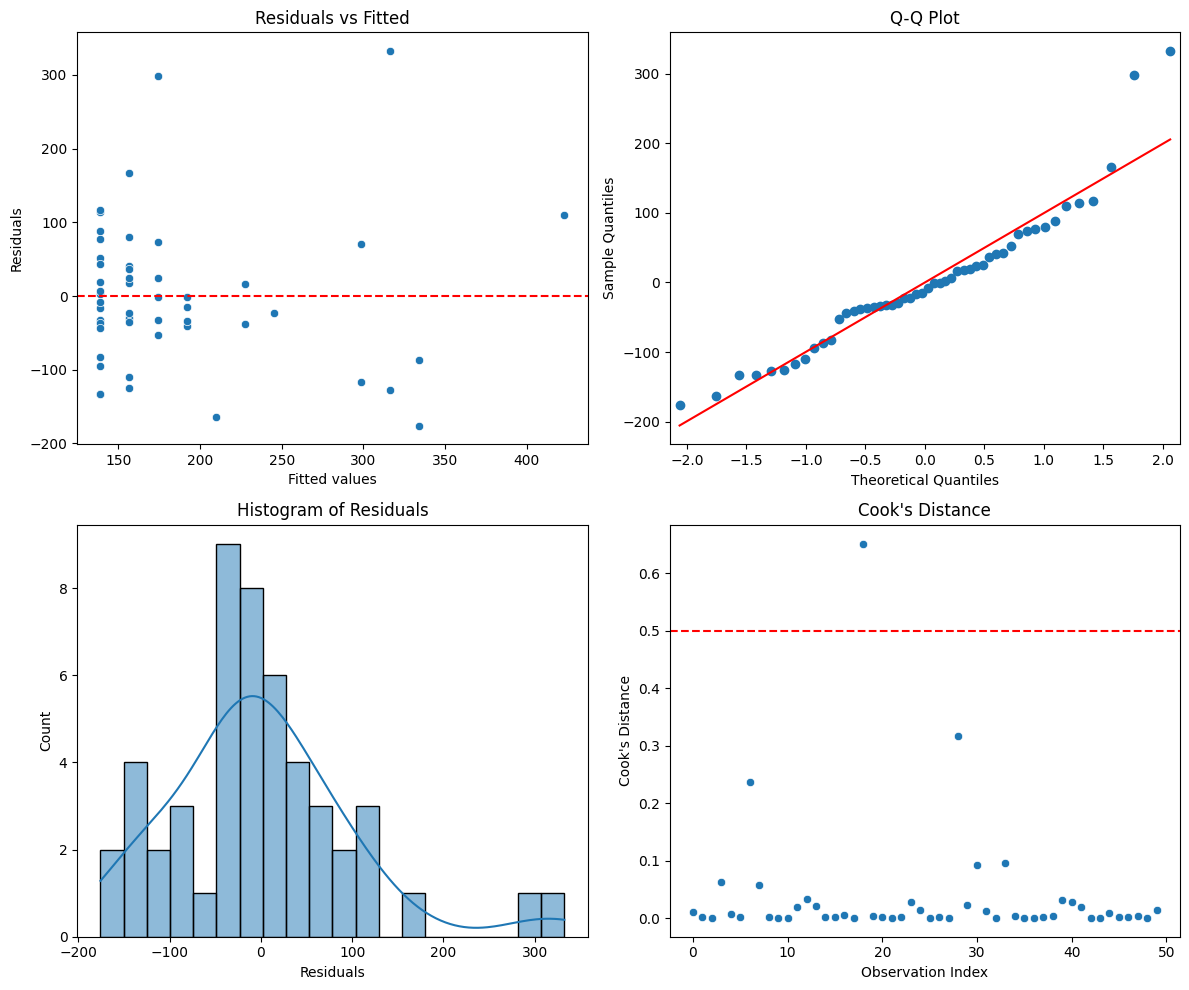

In [76]:
# run diagnostics since high skew/kurtosis indicates non-normality of residuals
# Durbin-watson test also indicates some possible autocorrelation

residuals = model.resid
fitted = model.fittedvalues
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(x=fitted, y=residuals, ax=axs[0, 0])
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

sm.qqplot(residuals, line='s', ax=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot')

sns.histplot(residuals, bins=20, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Histogram of Residuals')
axs[1, 0].set_xlabel('Residuals')

influence = model.get_influence()
(c, p) = influence.cooks_distance
sns.scatterplot(x=np.arange(len(c)), y=c, ax=axs[1, 1])
axs[1, 1].axhline(0.5, color='red', linestyle='--')
axs[1, 1].set_title("Cook's Distance")
axs[1, 1].set_xlabel("Observation Index")
axs[1, 1].set_ylabel("Cook's Distance")

plt.tight_layout()
plt.show()

# Summary: Looks like maybe some heteroscedasticity from residuals vs fitted plot. Q-Q shows deviance from normal residuals at the upper tail. Histogram confirms non-normality due to right skew. Cook's distance shows an outlier.
# Outcome: Try a GLM model based on distribution of response variable


# Robust Regression

In [8]:
# Fit a robust linear model that is less sensitive to outliers

X = sm.add_constant(snow["snow_depth_cm_accumulated"])
rlm_model = sm.RLM(snow["mean_arrival_delay"], X, M=sm.robust.norms.HuberT()).fit()
rlm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:     mean_arrival_delay   No. Observations:                   50
Model:                            RLM   Df Residuals:                       48
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 11 May 2025                                         
Time:                        15:13:24                                         
No. Iterations:                    25                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       127.5933     17.245      7.399      0.000      93.794     161.392
snow_depth_cm_accumulated    13.2933      3.325      3.998      0.000       6.777      19.810
=============================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

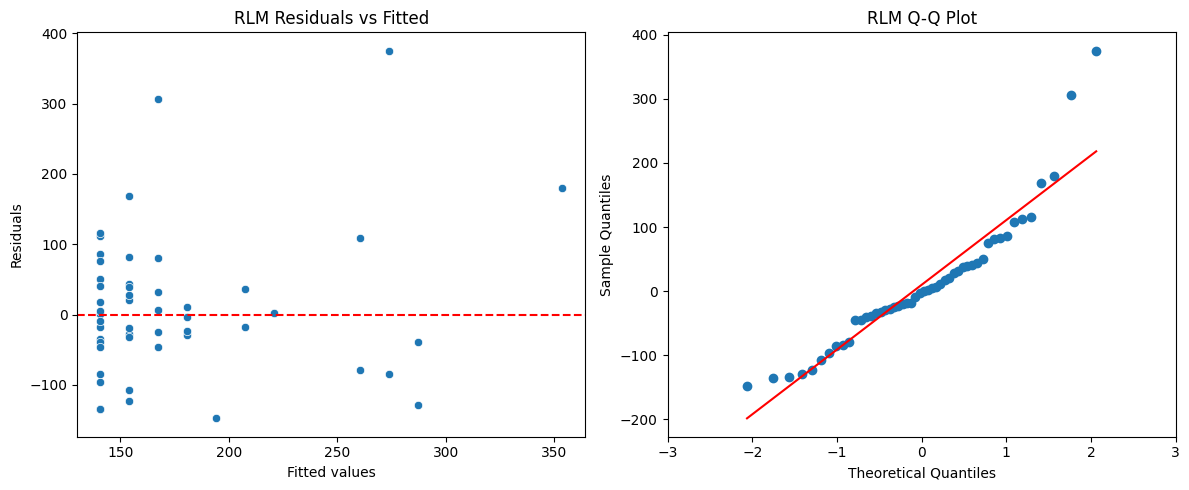

In [9]:
# Plot some diagnostics for the RLM model
rlm_fitted = rlm_model.fittedvalues
rlm_residuals = rlm_model.resid

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=rlm_fitted, y=rlm_residuals, ax=axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_title('RLM Residuals vs Fitted')
axs[0].set_xlabel('Fitted values')
axs[0].set_ylabel('Residuals')

sm.qqplot(rlm_residuals, line='s', ax=axs[1])
axs[1].set_title('RLM Q-Q Plot')
axs[1].set_xlim(-3, 3)

plt.tight_layout()
plt.show()

# Explore distribution

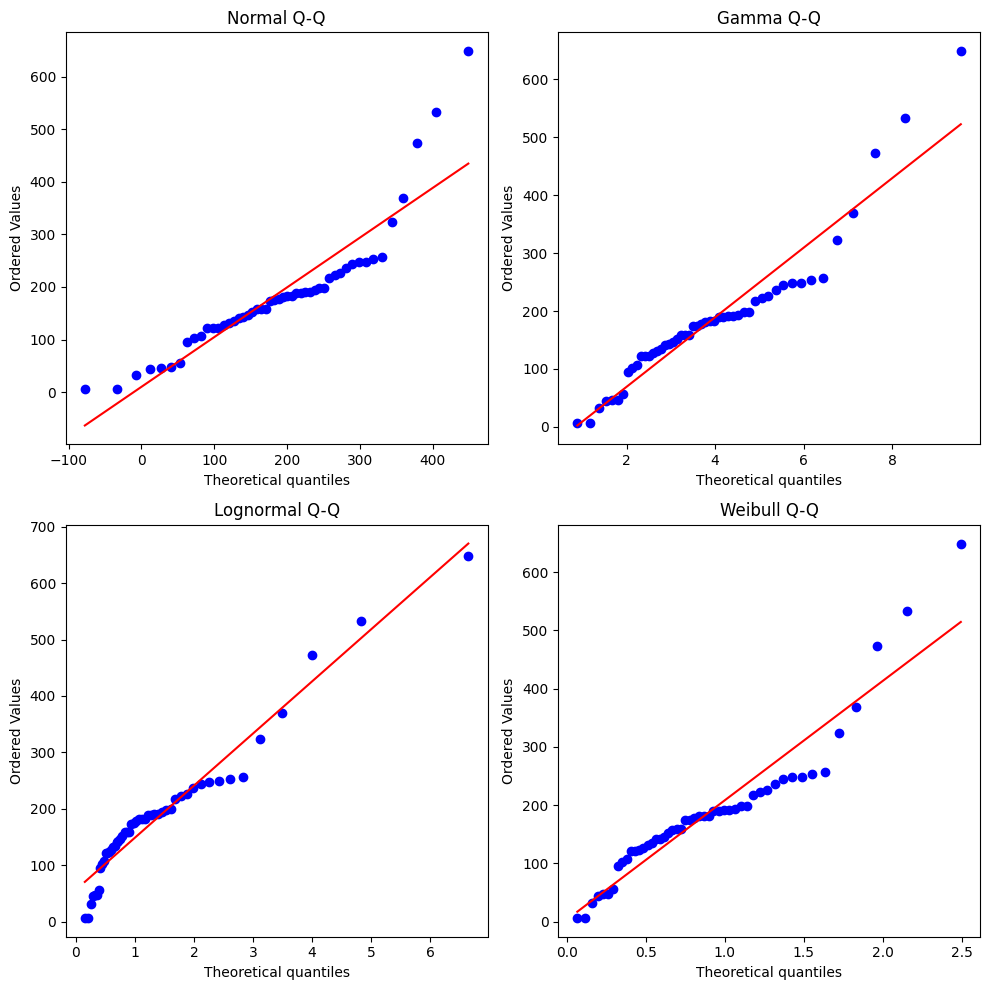

K-S Normal: statistic= 0.17694422540737598 p-value= 0.0769446257689469
K-S Gamma: statistic= 0.13180730619482983 p-value= 0.32136381365903555
K-S Lognormal: 0.22215670543334343 p-value= 0.011970326949693244
K-S Weibull: 0.1510089814028157 p-value= 0.18442654167581218


In [77]:
# first explore the distribution of the mean_arrival_delay variable

data = snow["mean_arrival_delay"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Normal
normal_params = stats.norm.fit(data)
stats.probplot(data, dist="norm", sparams=normal_params, plot=axs[0, 0])
axs[0, 0].set_title("Normal Q-Q")

# Gamma
gamma_params = stats.gamma.fit(data)
stats.probplot(data, dist="gamma", sparams=gamma_params[:-2], plot=axs[0, 1])
axs[0, 1].set_title("Gamma Q-Q")

# Lognormal
lognorm_params = stats.lognorm.fit(data, floc=0)
stats.probplot(data, dist="lognorm", sparams=(lognorm_params[0],), plot=axs[1, 0])
axs[1, 0].set_title("Lognormal Q-Q")

# Weibull
weibull_params = stats.weibull_min.fit(data, floc=0)
stats.probplot(data, dist="weibull_min", sparams=(weibull_params[0],), plot=axs[1, 1])
axs[1, 1].set_title("Weibull Q-Q")

plt.tight_layout()
plt.show()

ks_normal = stats.kstest(data, 'norm', args=normal_params)
ks_gamma = stats.kstest(data, 'gamma', args=gamma_params)
ks_lognorm = stats.kstest(data, 'lognorm', args=lognorm_params)
ks_weibull = stats.kstest(data, 'weibull_min', args=weibull_params)

print("K-S Normal: statistic=", ks_normal.statistic, "p-value=", ks_normal.pvalue)
print("K-S Gamma: statistic=", ks_gamma.statistic, "p-value=", ks_gamma.pvalue)
print("K-S Lognormal:", ks_lognorm.statistic, "p-value=", ks_lognorm.pvalue)
print("K-S Weibull:", ks_weibull.statistic, "p-value=", ks_weibull.pvalue)

# Summary: statistics show that gamma distribution is a decent fit for our response data despite the visual suggestion of lognormal
# Outcome: fit a gamma distribution

# Gamma GLM with log link function

In [78]:
glm_model = smf.glm(
    formula="mean_arrival_delay ~ snow_depth_cm_accumulated",
    data=snow,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

glm_model.summary()


# Summary: significant, positive coefficient. Decently high Pseudo R-squared of 0.2 means our model explains the data better than the null model
# Outcome: check residuals

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     mean_arrival_delay   No. Observations:                   50
Model:                            GLM   Df Residuals:                       48
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                         0.28706
Method:                          IRLS   Log-Likelihood:                -300.57
Date:                Sun, 11 May 2025   Deviance:                       20.712
Time:                        22:16:35   Pearson chi2:                     13.8
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2720
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.9064      0.106     46.372      0.000       4.699       5.114
snow_depth_cm_accumulated     0.0751      0.020      3.680      0.000       0.035       0.115
=============================================================================================
"""

Interpreted based on exp: 
- `exp(4.9064) = 135` seconds which is expected delay when no snow accumulation in the past 25 hours
- `exp(0.0751) = 1.07799194469` meaning every cm of snow leads to **7.8%** expected increase in mean delay

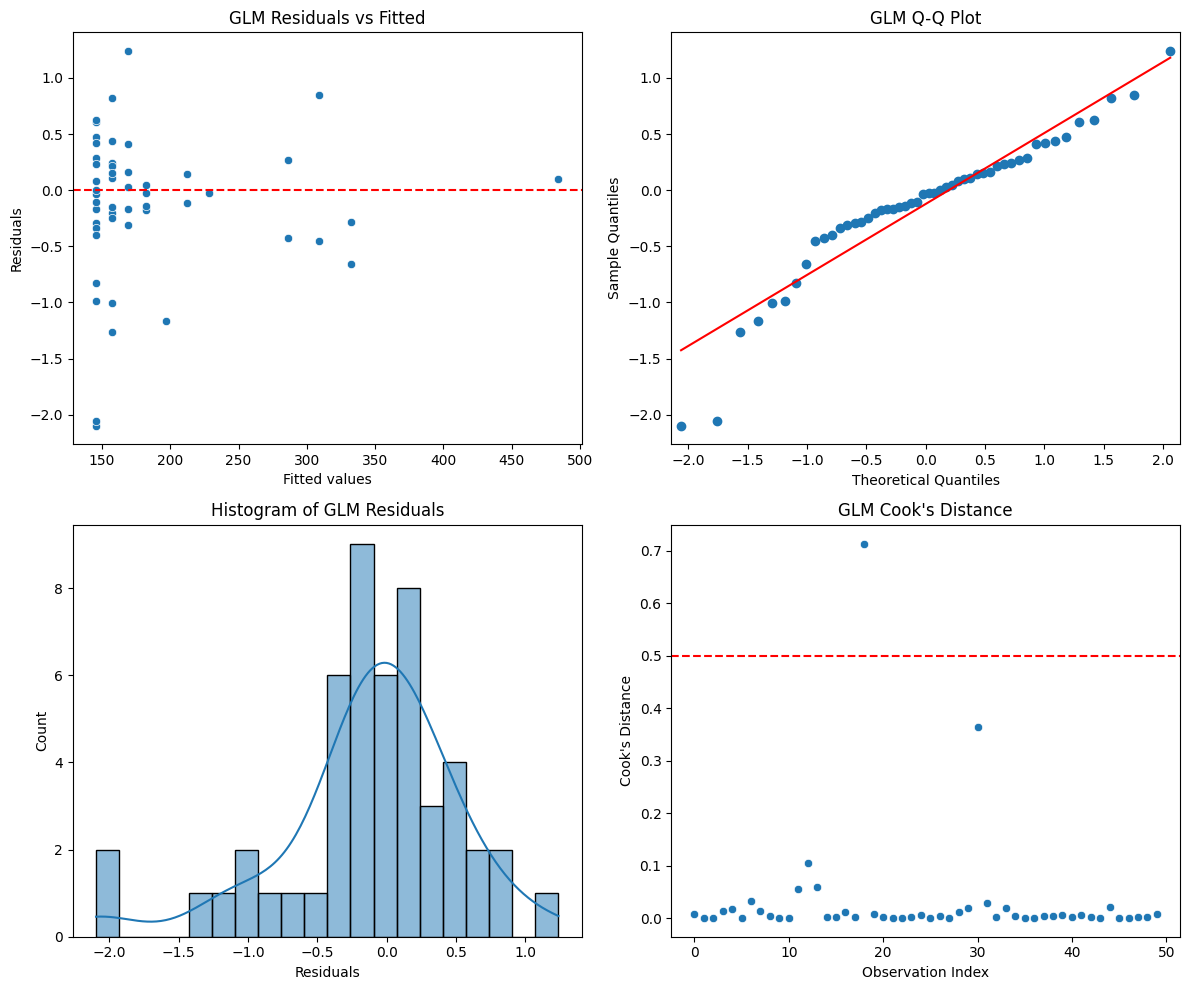

In [79]:
# Extract fitted values and deviance residuals from the GLM
residuals = model.resid
fitted = model.fittedvalues
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

fitted = glm_model.fittedvalues
residuals = glm_model.resid_deviance

sns.scatterplot(x=fitted, y=residuals, ax=axs[0, 0])
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_title('GLM Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

sm.qqplot(residuals, line='s', ax=axs[0, 1])
axs[0, 1].set_title('GLM Q-Q Plot')

sns.histplot(residuals, bins=20, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Histogram of GLM Residuals')
axs[1, 0].set_xlabel('Residuals')

influence = glm_model.get_influence()
(c, p) = influence.cooks_distance
sns.scatterplot(x=np.arange(len(c)), y=c, ax=axs[1, 1])
axs[1, 1].axhline(0.5, color='red', linestyle='--')
axs[1, 1].set_title("GLM Cook's Distance")
axs[1, 1].set_xlabel("Observation Index")
axs[1, 1].set_ylabel("Cook's Distance")

plt.tight_layout()
plt.show()

# Summary:  
# Residuals vs. Fitted: No clear pattern, variance is fairly constant so homoscedasticity is mostly satisfies
# Q-Q: Follows the line well expect for the tails, indicating normality is not perfect
# Histogram: Some left skew but not too bad, approx normal
# Cook: One outlier but keep it because it's a real observation
#  

In [13]:
deviance = glm_model.deviance
df_resid = glm_model.df_resid


print("deviance:", deviance, "df_resid", df_resid, "dev/df_resid:", deviance / df_resid)

deviance: 20.71165135545482 df_resid 48 dev/df_resid: 0.4314927365719754


In [80]:
glm_model_with_precipitation = smf.glm(
    formula="mean_arrival_delay ~ snow_depth_cm_accumulated + prec_mm_6h:temp",
    data=snow,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

glm_model_with_precipitation.summary()

# Results: temp and prec_mm_total_24h are not significant
# Outcome: remove them and try with prec_mm_6h:temp

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     mean_arrival_delay   No. Observations:                   50
Model:                            GLM   Df Residuals:                       47
Model Family:                   Gamma   Df Model:                            2
Link Function:                    Log   Scale:                         0.27976
Method:                          IRLS   Log-Likelihood:                -300.36
Date:                Sun, 11 May 2025   Deviance:                       20.448
Time:                        22:16:48   Pearson chi2:                     13.1
No. Iterations:                    14   Pseudo R-squ. (CS):             0.2915
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.8829      0.105     46.343      0.000       4.676       5.089
snow_depth_cm_accumulated     0.0728      0.021      3.542      0.000       0.033       0.113
prec_mm_6h:temp              -0.0352      0.034     -1.024      0.306      -0.103       0.032
=============================================================================================
"""

In [81]:
glm_model_with_precipitation = smf.glm(
    formula="mean_arrival_delay ~ snow_depth_cm_accumulated + C(ground_expl)",
    data=snow,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

glm_model_with_precipitation.summary()

# Results: ground_expl is not significant (makes sense since most of them are the same)
# Outcome: best model is the one with snow_depth_cm_accumulated only

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     mean_arrival_delay   No. Observations:                   50
Model:                            GLM   Df Residuals:                       47
Model Family:                   Gamma   Df Model:                            2
Link Function:                    Log   Scale:                         0.28975
Method:                          IRLS   Log-Likelihood:                -300.29
Date:                Sun, 11 May 2025   Deviance:                       20.602
Time:                        22:16:54   Pearson chi2:                     13.6
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2754
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             4.8758      0.117     41.739      0.000       4.647       5.105
C(ground_expl)[T.partial_snow_packed_wet_el_half]     0.1360      0.225      0.604      0.546      -0.305       0.577
snow_depth_cm_accumulated                             0.0780      0.021      3.709      0.000       0.037       0.119
=====================================================================================================================
"""

# Leave One Out Cross Validation

In [16]:
# leav one out cross-validation
def leave_one_out_cross_validation(X, y, kind):
    loo = LeaveOneOut()
    X_np = sm.add_constant(X).to_numpy()
    y_np = y.to_numpy()

    errors = []

    for train_index, test_index in loo.split(X_np):
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        if kind == "GLM":
            glm_loo = sm.GLM(
                y_train,
                X_train,
                family=sm.families.Gamma(link=sm.families.links.Log())
            ).fit()
            y_pred = glm_loo.predict(X_test)[0]

        elif kind == "RLM":
            rlm_loo = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
            y_pred = rlm_loo.predict(X_test)[0]
        elif kind == "OLS":
            ols_loo = sm.OLS(y_train, X_train).fit()
            y_pred = ols_loo.predict(X_test)[0]
        else:
            raise ValueError("Invalid model kind.")

        error = (y_test[0] - y_pred) ** 2
        errors.append(error)

    mse = np.mean(errors)
    print("Leave-One-Out Cross-Validation for ", kind)
    print("RMSE:", np.sqrt(mse), "seconds")
    print("Mean delay STD:", np.std(y), "seconds")
    print()

leave_one_out_cross_validation(snow["snow_depth_cm_accumulated"], snow["mean_arrival_delay"], "OLS")
leave_one_out_cross_validation(snow["snow_depth_cm_accumulated"], snow["mean_arrival_delay"], "RLM")
leave_one_out_cross_validation(snow[["snow_depth_cm_accumulated"]], snow["mean_arrival_delay"], "GLM")

Leave-One-Out Cross-Validation for  OLS
RMSE: 106.50019652752718 seconds
Mean delay STD: 119.43529187898702 seconds

Leave-One-Out Cross-Validation for  RLM
RMSE: 109.60129909588954 seconds
Mean delay STD: 119.43529187898702 seconds

Leave-One-Out Cross-Validation for  GLM
RMSE: 104.83509065032341 seconds
Mean delay STD: 119.43529187898702 seconds



On average, using snow_depth_cm_accumulated to predict delay has an error of 104 seconds. Since this is lower than the STD it indicates that our regression is better than just guessing, but not really by much...